# COMP3717 - Introduction to Music Processing - Practical 2
## Frequency-domain representations and the Fourier transform

Eamonn Bell  
<eamonn.bell@durham.ac.uk>

2024-01-29 (rev. 1)

By the end of this practical you should able to:

- implement the Discrete Fourier Transform
- use the Short-Time Fourier Transform (STFT) to produce spectrograms
- understand and effectively use the parameters of STFT
- use an implementation of the inverse Fourier Transform

This notebook is for non-commercial use only, and freely adapts material from:

- Meinard Müller and Sebastian Rosenzweig: PCP Notebooks: A Preparation Course for Python with a Focus on Signal Processing. The Journal of Open Source Education (JOSE), 5(47), 2022. [[site]](https://www.audiolabs-erlangen.de/resources/MIR/PCP/PCP.html) (MIT License)
- Meinard Müller: Fundamentals of Music Processing – Using Python and Jupyter Notebooks. 2nd edition, Springer Verlag, 2021. [[notebooks]](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C0/C0.html) (Code: MIT License, Text and figures: CC BY-NC-SA 4.0 DEED)


In [3]:
from libfmp.c1 import generate_tone, generate_chirp_exp_octave
from libfmp.c2 import dft, fft, ifft, stft, istft
from libfmp.b import plot_matrix

from matplotlib import pylab as plt

import IPython.display as ipd
import librosa
import math
import numpy as np

In [4]:
%matplotlib inline

## Introduction

Our objective today is to build up a toolkit for analysing audio files using the Fourier Transform. Let's look ahead at where we are heading and first load up two recordings of the same note, played by different instruments, and look at their waveform plots (see Practical 1 for details)

In [5]:
piano_xs, piano_Fs = librosa.load('./FMP_C2_F05a_C4_piano.wav', sr=8000)
trumpet_xs, trumpet_Fs = librosa.load('./FMP_C2_F05b_C4_trumpet.wav', sr=8000)

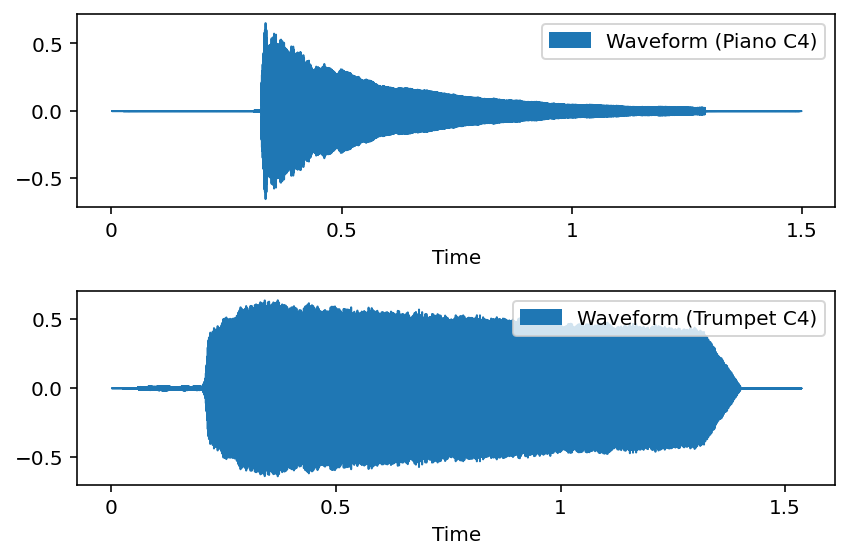

In [6]:
fig, axs = plt.subplots(2, 1)

librosa.display.waveshow(piano_xs, ax=axs[0], label='Waveform (Piano C4)')
librosa.display.waveshow(trumpet_xs, ax=axs[1], label='Waveform (Trumpet C4)')

axs[0].legend()
axs[1].legend()

plt.tight_layout()
plt.show()

The Fourier transform of each of these signals returns a set of complex numbers that can be interpreted as telling us how the signal is a mix of simpler sounds, modeled by the sum of many sinusoids of a given frequency, magnitude, and phase. 

In particular, the transform can be used to determine a magnitude coefficient and a phase coefficient for each sinusoidal component of a given frequency. 

We know from lecture that there is a relationship between trigonometry (e.g. $\sin$, $\cos$ etc.) and complex numbers (i.e. $c \in \mathbb{C}$, expressed in Cartesian form $c = a + ib$ with $i^2 = 1$), so most implementations of the Fourier transform will return complex-valued results, which we need to know how to deal with in order to recover the phase and magnitude information of interest.

Finally, we note that naive implementations of the Fourier transform are exceptionally slow (quadratic in $N$, the number of samples under consideration), and in practice something called the Fast Fourier Transform (FFT) is used. 

Recall that the FFT is usually set up for some $N$ that is an integer power of 2, so that the recursive set up can take advantage of the symmetries in the Fourier transform. This means in practice that if we want to study a signal with $L$ samples in it using the FFT, we zero-pad (in this case at the end) so that the buffer is of length $N = 2^{\lfloor{\log_{2}{L}}\rfloor + 1}$. 

Taking all this together we can use an existing implementation of the FFT as something of a black box, to first get a sense for the kinds of results it produces.

In [7]:
def simple_fft(xs):
    L = len(xs)
    pad_target_exp = math.floor(math.log2(L)) + 1
    N = 2 ** pad_target_exp
    padded_xs = np.pad(xs, pad_width=(0, N - L), constant_values=0)
    return fft(padded_xs)

In [8]:
piano_X = simple_fft(piano_xs)
trumpet_X = simple_fft(trumpet_xs)

We know that the input data is an array of real-valued numbers of length `N` (which we got by padding the original signal, so that the FFT works). The output data is also of length `N`. 

In [9]:
len(piano_xs), 2 ** math.floor(math.log2(len(piano_xs)) + 1)  , len(piano_X)

(33019, 65536, 65536)

Note also the data type of the return value of `simple_fft`:

In [10]:
type(piano_X), piano_X.dtype

(numpy.ndarray, dtype('complex128'))

Recall from lecture that it is a matter of convention and convenience that we set the number frequencies over which the transform is computed ($M$ in the lecture material in the first introduction to the discrete case of the Fourier transform) to the number of samples ($N$ in the lecture material), so that we speak of ranging over $N$ from this point on.

So, given a DT-signal with 65,536 samples (admittedly some of these are zeros, from the padding step - again, just done for speed), the Fast Fourier Transform `libfmp.c2.c2_fourier.fft` returns 65,536 complex numbers, each of which corresponds to coefficients for one of 65,536 elements of the "recipe" which makes up the orignal signal, which are (loosely) called the frequency components of the original signal. Here is the 4th component:

In [11]:
piano_X[4]

(22.124534228405203-13.439779042856632j)

Python supports complex numbers, using `1j` to represent $i = \sqrt{-1}$ (i.e. the number that fulfills the definition $i^2 := -1$), which is a long-standing and - in this context - somewhat confusing engineering convention. For example, the complex number $c_1 = 3 + 4i$ can be constructed in Python, as follows:

In [12]:
c1 = 3 + 4j

Recall that from lecture there are two equivalent ways to specify a complex number: Cartesian form and polar co-ordinate form. 

- In Cartesian form, a complex number is expressed as a sum of a real part and an imaginary part. 
- In polar form, the same complex number is represented as a combination of a direction and a magnitude. 

We can get the magnitude of the complex number (or its **absolute value**) using `np.abs` or with a simple computation over the the real (`np.real`) and imaginary (`np.imag`) parts, applying Pythagoras's theorem.

In [13]:
assert(np.abs(c1) == math.sqrt(np.real(c1) ** 2 + np.imag(c1) ** 2))

We can get the angle of a complex number (measured in radians: there are $2\pi$ radians in a circle) using `np.angle`:

In [14]:
np.angle(1 + 1j)

0.7853981633974483

Recall from Practical 1 that many mathematical operators are overloaded so that they work just as well on NumPy arrays, so you can just as easily use the code above on an array of complex numbers `A = [c1, c2, ..., cn]`.

## P1.1 Plotting complex numbers

Write a function `plot_complex(c)` that plots a complex number in Cartesian co-ordinate form 


In [15]:
def plot_complex(c):
    """Plot a complex number in Cartesian coordinate form

    Args:
        c (complex): Complex number
    """
    fig, ax = plt.subplots()

    ax.spines[["left", "bottom"]].set_position(("data", 0))
    ax.spines[["top", "right"]].set_visible(False)
    ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False)
    ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)
    
    ax.set_xlabel(r'$\Re(c)$')
    ax.set_ylabel(r'$\Im(c)$')


    # STUDENTS MODIFY THIS LINE
    ax.scatter(np.real(c), np.imag(c))
    plt.show()

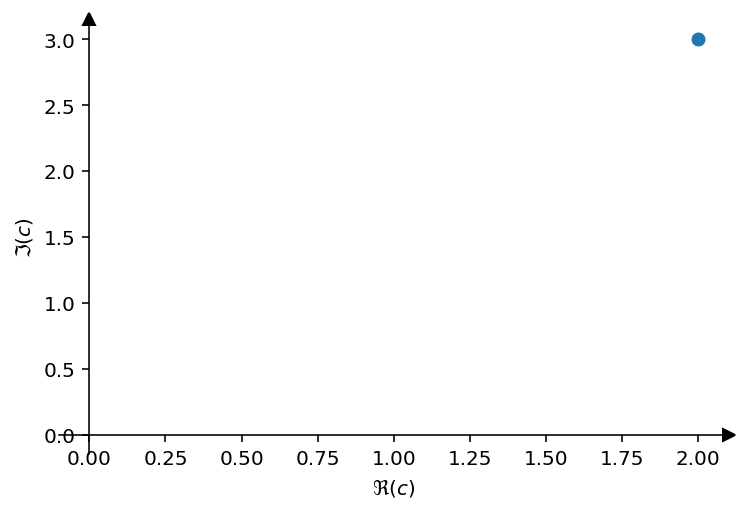

In [16]:
plot_complex([2 + 3j])

## P1.2 Rotating complex numbers 

[PCP 06 Ex. 1](https://www.audiolabs-erlangen.de/resources/MIR/PCP/PCP_06_complex.html)

Write a function `rotate_complex(c, r)` that rotates a complex number $c$ by $r$ degress in a clockwise direction. Apply this function for $c = 1 + 0.5i$ and $r \in \{10, 20, 30\}$ 

> To do this, you might find the `np.deg2rad` function helpful, as well as to recall that $c$ may also be written as $c = |c|\cdot\exp(i\gamma)$, where $\exp(i\gamma) := \cos(\gamma) + i\sin(\gamma)$. You do not necessarily need to use the exponential function in your solution, however.

The following plot may help you understand this relationship more graphically:

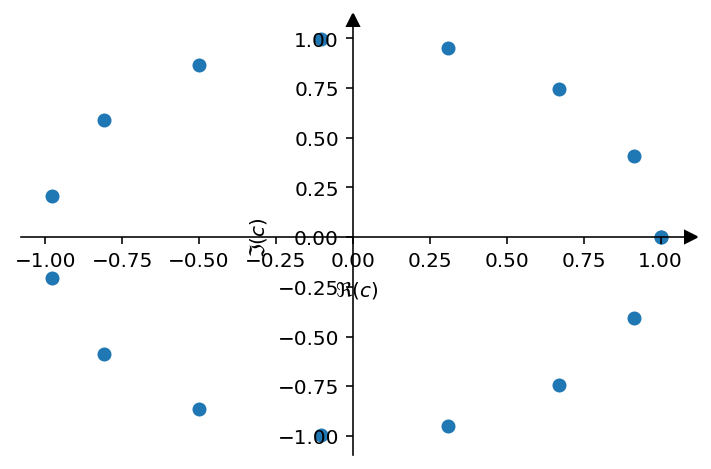

In [17]:
w_max = 8 
plot_complex(np.exp(1j * np.linspace(0, 2 * np.pi, 16)))

In [18]:
def rotate_complex(c, r):
    """Rotate complex number

    Args:
        c (complex): Complex number
        r (scalar): Angle in degrees
    """
    # STUDENTS MODIFY THESE LINES
    c_angle_rad = np.angle(c) - np.deg2rad(r)
    c_abs = np.abs(c)
    a = c_abs * np.cos(c_angle_rad)
    b = c_abs * np.sin(c_angle_rad)
    c_rot = a + b * 1j
    return c_rot

You can test your solution with the following assertion/unit test, if you like:

In [19]:
assert(np.all(np.isclose([rotate_complex(1 + 0.5j, r) for r in [10, 20, 30]], [(1.0716318418456732+0.3187556988391737j),
 (1.1107026924487426+0.12782616706728547j), (1.1160254037844386-0.06698729810778065j)])))

## P2.1 A naive implementation of the DFT

We will use our understanding of the DFT to produce a naive (and highly inefficient) implementation `naive_DFT(signal)`, which takes as input a real-valued signal represented in a NumPy array and returns the result of applying the DFT to that signal.

You should test your implementation on the following signal. Do not increase the duration or the sample rate, as the most straightforward approach will be long-running for even relatively small signals.

In [20]:
xs, t = generate_tone(p=60, weight_harmonic=[0.3, 0.2], Fs=2048, dur=0.25)

For this signal, if you plot the magnitude of the component co-efficients coming from the DFT, you should see something like this, which has a symmetry that we will explain in the next section.

```python
ndft = naive_DFT(xs)
plt.plot(np.abs(ndft))
plt.show()
```

<nop/> <div style="width: 300px;">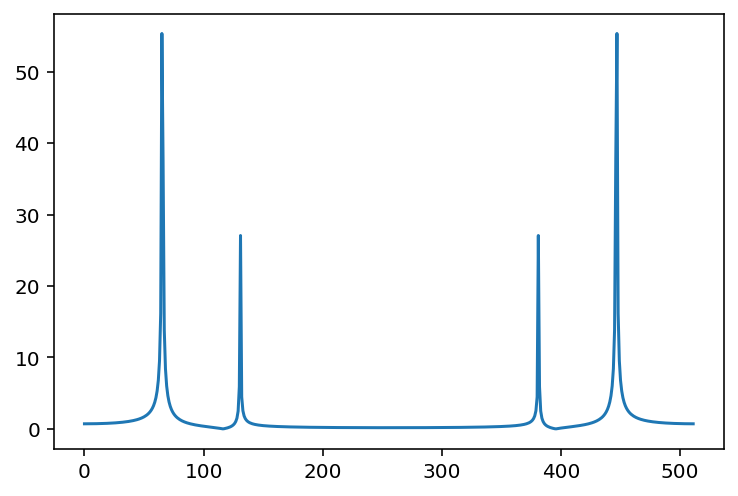</div>

In [21]:
def naive_DFT(signal):
    """Compute the discrete Fourier transform (DFT)
    
    Args:
        x (np.ndarray): Signal to be transformed

    Returns:
        X (np.ndarray): The discrete Fourier transform, 
          where X[k] is the k-th component, as a complex
          number.
    """
    # STUDENTS TO CHANGE
    N = len(signal)
    M = N
    X = np.zeros_like(signal)
    
    for k in range(M):
        component = 0
        for n in range(N):
            # STUDENTS TO PROVIDE
            factor = np.exp(-2 * np.pi * 1j * k * (n/N))
            component += signal[n] * factor
        X[k] = component
    return X

## P2.2 Practicalities of frequency-magnitude plots

Using `simple_fft`, write a function `frequency_magnitude` that accepts a real signal `x` and a sample rate `Fs` and creates a **meaningful** frequency-magnitude plot. You may want to consult Section 2.1.3 of [Müller](https://discover.durham.ac.uk/permalink/44DUR_INST/k3s6qp/alma991010666802207366), especially p. 51-52. 

Once your implementation is complete, use it to examine the difference in **frequency spectra** betweeen the piano and trumpet recording

```python
frequency_magnitude(piano_xs, piano_Fs)
frequency_magnitude(trumpet_xs, trumpet_Fs)
```

In [22]:
def frequency_magnitude(x, Fs):
    """Produce a frequency-magnitude plot given a real signal.
    
    Args:
        x (np.ndarray): Real-valued signal to be transformed
        Fs (int): Sample rate
    """
    # STUDENTS MODIFY THIS LINE
    X = simple_fft(x)
    # STUDENTS MODIFY THIS LINE
    N = len(X)
    # STUDENTS MODIFY THIS LINE
    plt.plot(np.arange(N//2) * Fs / N, np.abs(X)[:N//2])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')

Before we move on, let's examine the relationship between sample rate and the level of detail provided in a given frequency-magnitude plot. 

We can use the `librosa.resample` function to take a time-domain representation and change its sampling rate. 
Whether increasing it (**upsampling**) or decreasing it (**downsampling**), this operation does not perfectly preserve the frequency content of a signal.

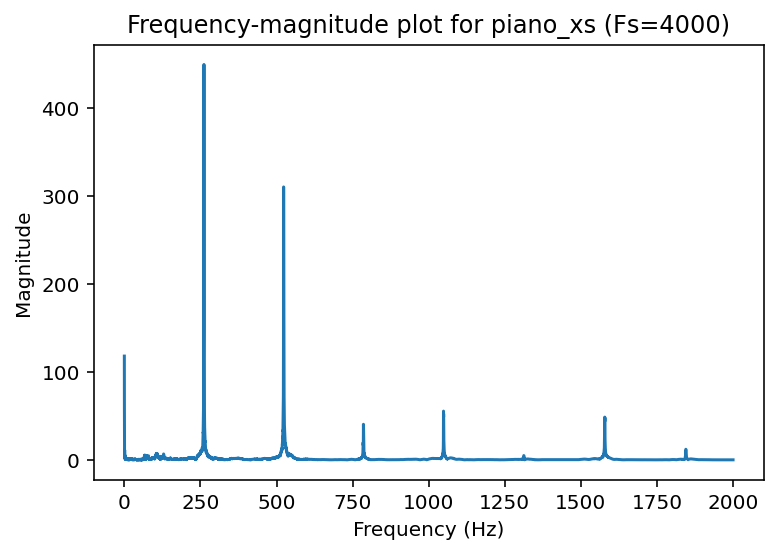

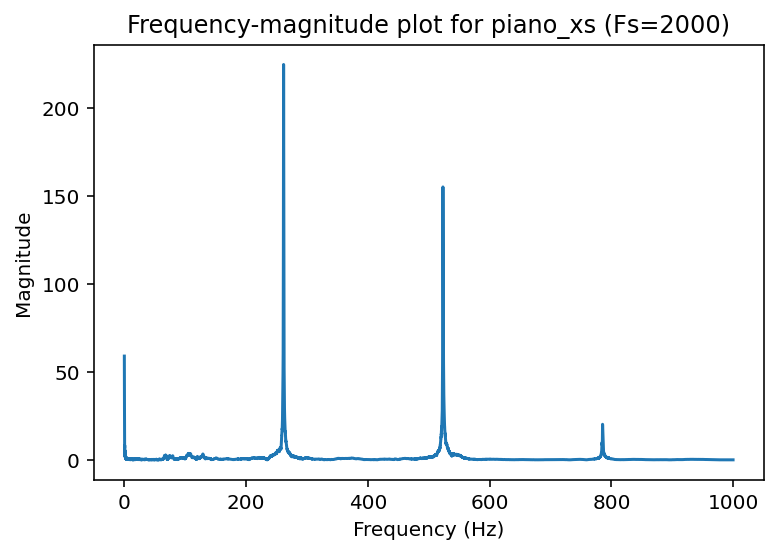

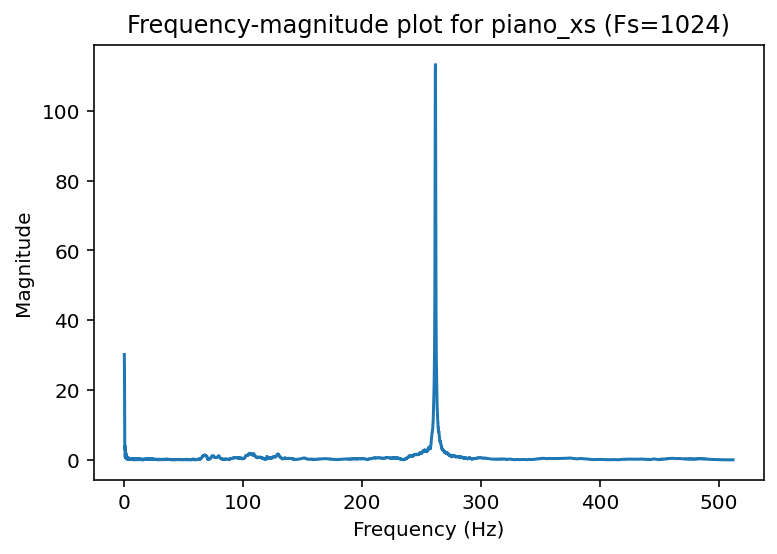

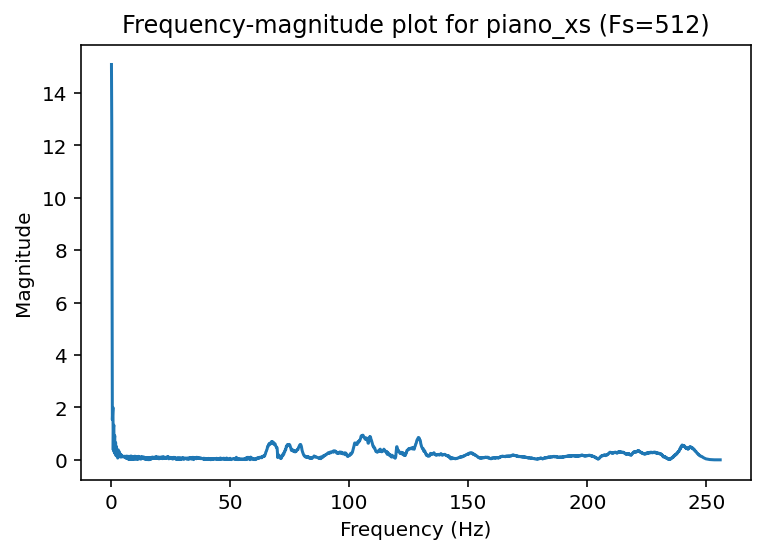

In [23]:
for target_Fs in [4000, 2000, 1024, 512]:
    resampled_xs = librosa.resample(y=piano_xs, orig_sr=piano_Fs, target_sr=target_Fs)
    frequency_magnitude(resampled_xs, target_Fs)
    plt.title(f'Frequency-magnitude plot for piano_xs (Fs={target_Fs})')
    plt.show()

## P3.1 Implementing the STFT

Recall the definition of the short-time Fourier transform (STFT):

$$\mathcal{X}(m, k) = \sum_{n=0}^{N-1}x(n + mH)w(n)\exp(-2\pi ikn/N)$$

The interpretation of the variables can be found in the lecture material.

Using `simple_fft`, write a function `stft_basic` that accepts a real signal `x`, a window function `w` (as an array), a hop size `H`, and returns a two-dimensional array `X` containing the results of the discrete Short-Time Fourier Transform.

By using `simple_fft` above, you will not have to compute the Fourier transform the STFT yourself - this can be delegated. But you will have to ensure that you correctly advance through the signal according to the specified parameters.

You may wish to make use of `np.zeros`, to create an empty NumPy array of the correct shape to hold the results of the STFT, and `np.floor`, in computing this size (among other things).

In [24]:
def stft_basic(x, w, H=8, only_positive_frequencies=False):
    """Compute a basic version of the discrete short-time Fourier transform (STFT)
    
    Args:
        x (np.ndarray): Signal to be transformed
        w (np.ndarray): Window function (implies N)
        H (int): Hop size (Default value = 8)
        only_positive_frequencies (bool): Return only positive frequency part of spectrum (non-invertible)
            (Default value = False)

    Returns:
        X (np.ndarray): The discrete short-time Fourier transform
    """
    N = len(w)
    L = len(x)
    
    # STUDENT VERSION TO CHANGE THIS
    M = np.floor((L - N) / H).astype(int) + 1
    X = np.zeros((N, M), dtype='complex')
    for m in range(M):
        # STUDENT VERSION TO CHANGE THIS
        x_win = x[m * H:m * H + N] * w
        # STUDENT VERSION TO CHANGE THIS
        X_win = np.fft.fft(x_win)
        X[:, m] = X_win

    if only_positive_frequencies:
        K = 1 + N // 2
        X = X[0:K, :]
    return X

## P3.2 STFT parameters and spectrograms

The `plot_matrix` function is a simple wrapper around `matplotlib` that can be used to produce visualisations of spectral vectors coming from the STFT. In particular, you can use this to plot the **power spectrogram** of a signal, after performing an appropriate transform.

Load up two signals: a single note played on the violin, with audible low-frequency modulations in the fundamental frequency (**vibrato**); a "chirp" signal, a sine tone which starts at a fixed frequency (`freq_start`) and gradually increases to reach (`2 * freq_start`) by the end of the duration. 

In [25]:
Fs = 8000
violin_xs, violin_Fs = librosa.load('./FMP_C2_F05c_C4_violin.wav', sr=Fs, offset=1, duration=8)
chirp_xs, chirp_t = generate_chirp_exp_octave(freq_start=440, dur=8, Fs=Fs, amp=1)

Study the following code, which explores the effect of different choices of `N` (number of samples per STFT window) and `H` (hop length) on the power spectrogram produced by a given STFT. What is the relationship between the temporal resolution and the frequency resolution of the visualisation you produce? 

It uses the implementation of `stft_basic` that you have completed above; if you have not completed this successfully, you can `from libfmp.c2 import stft_basic`.

The code below implements a Hann window (using `np.hanning`). What happens if you change this to a square window, as shown in lecture? In order to complete this task, you may want to look at precisely what `np.hanning(N)` returns for a given choice of N. 

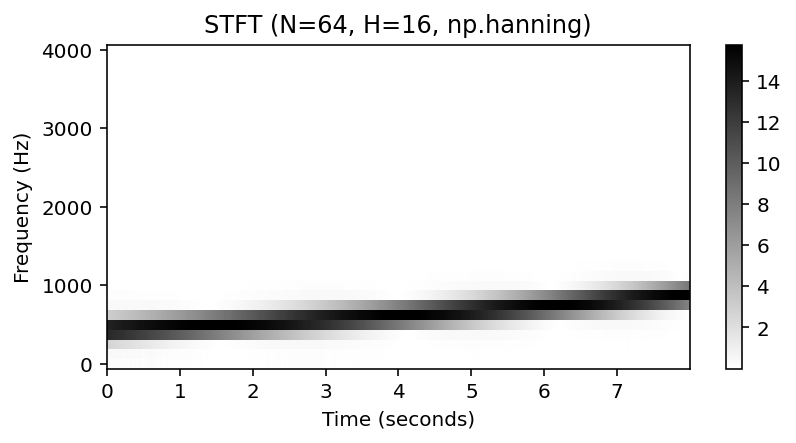

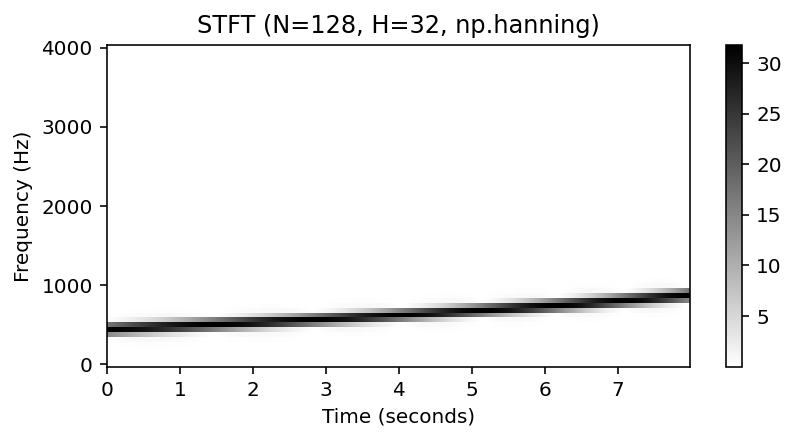

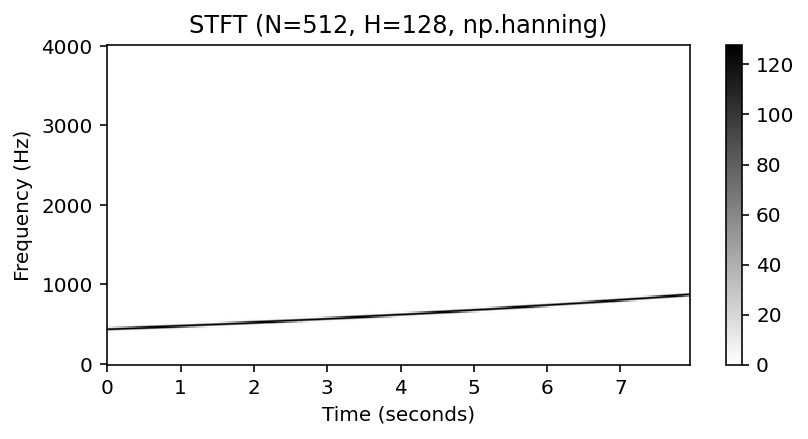

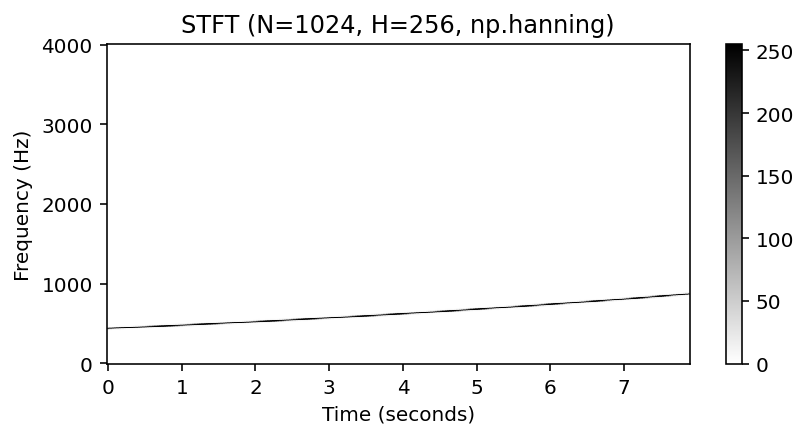

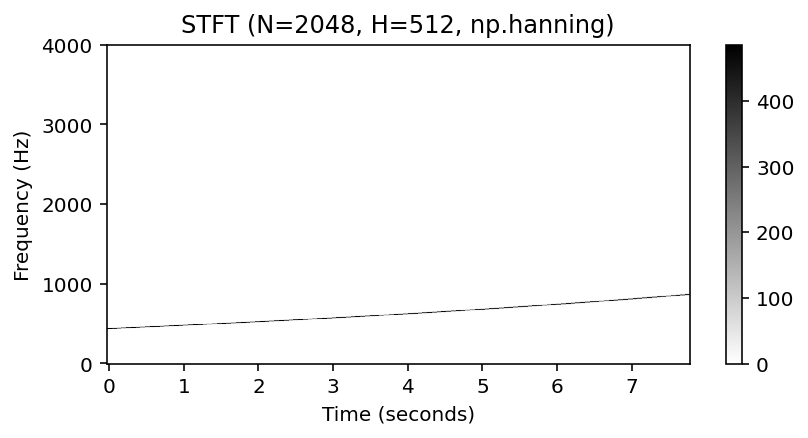

In [26]:
for N in [64, 128, 512, 1024, 2048]:
    H = N // 4
    w = np.hanning(N)
    X = stft_basic(chirp_xs, w, H, only_positive_frequencies=True)
    plot_matrix(np.abs(X), Fs=Fs/H, Fs_F=N/Fs)
    plt.title(f'STFT (N={N}, H={H}, np.hanning)')
    plt.show()

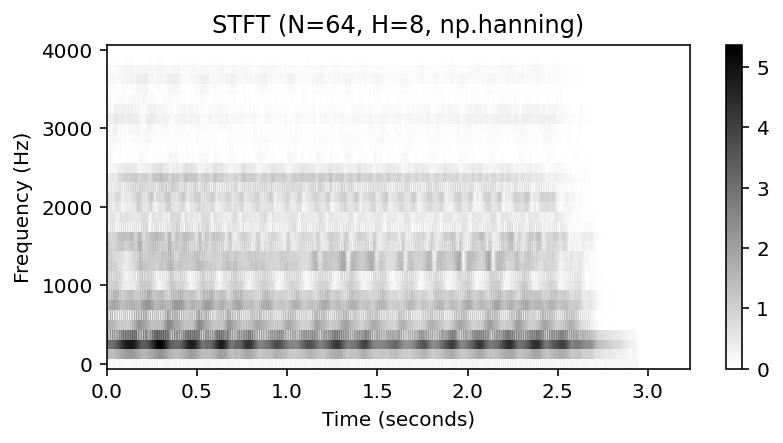

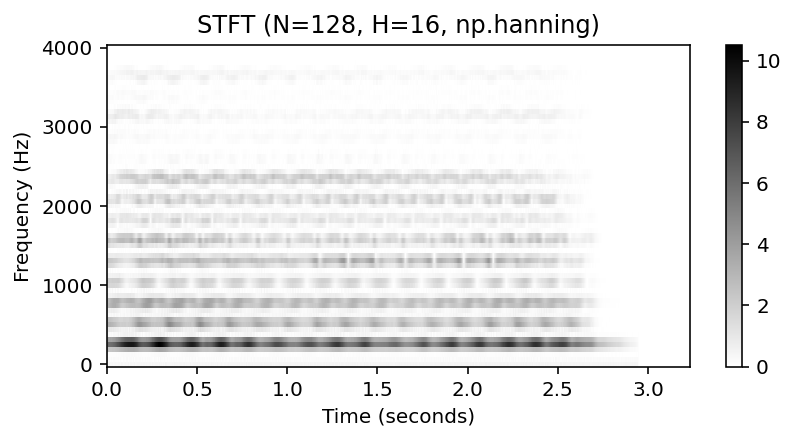

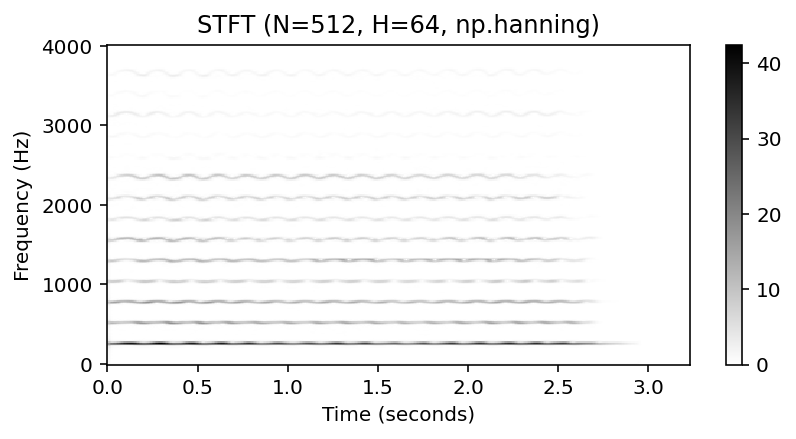

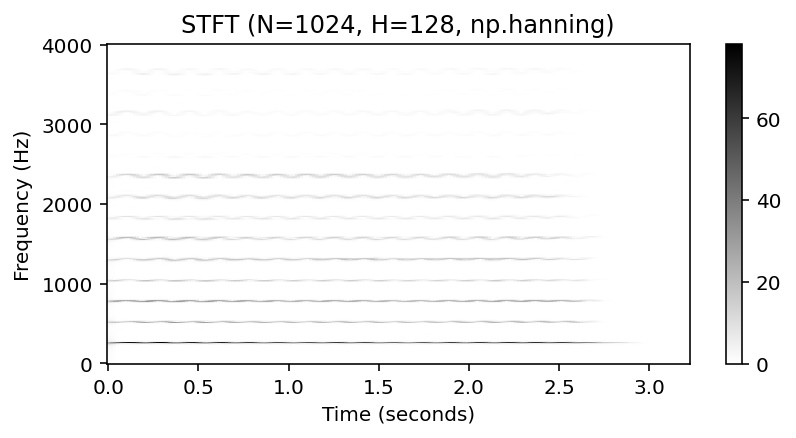

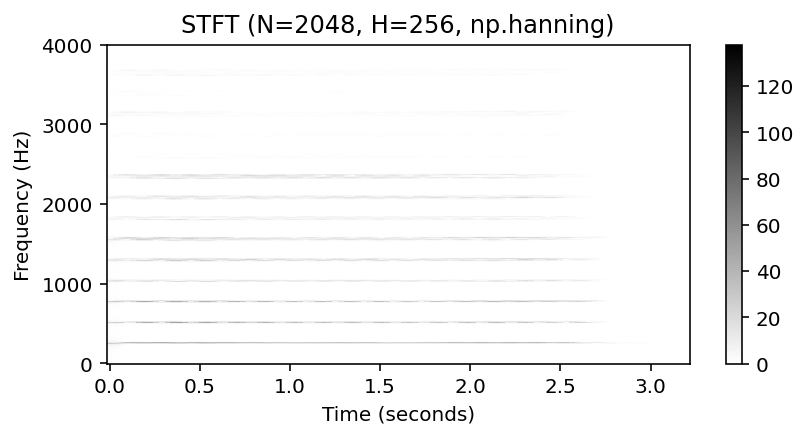

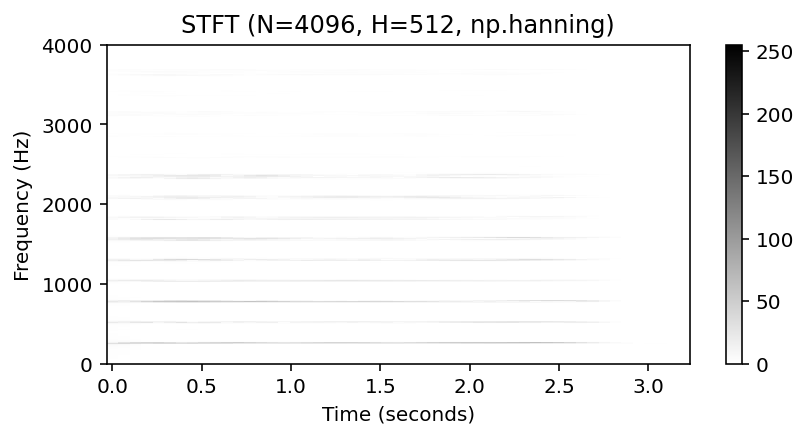

In [27]:
for N in [64, 128, 512, 1024, 2048, 4096]:
    H = N // 8
    w = np.hanning(N)
    X = stft(violin_xs, w, H, zero_padding=0, only_positive_frequencies=True)
    plot_matrix(np.abs(X), Fs=Fs/H, Fs_F=N/Fs)
    plt.title(f'STFT (N={N}, H={H}, np.hanning)')
    plt.show()

## P3.3 The Inverse Fourier Transform and the Inverse Short-Time Fourier Transform

One of the other motivations for setting $M$ (the number of coeffcients to return) to $N$ (the number of samples to process) is that it helps make the Fourier Transform - if we think about it as a matrix, a bit out of scope - invertible, giving rise to the Inverse Fourier Transform. 

We do not go into the details here, but `libfmp` provdes a function `ifft`, which takes a frequency-domain representation of a signal represented by the complex coefficients produced by the Fourier Transform, and produces the time-domain representation of *the same signal*.

In [28]:
chirp_xs, chirp_t = generate_chirp_exp_octave(freq_start=200, dur=0.25, Fs=8000, amp=1)

In [29]:
ipd.Audio(chirp_xs, rate=8000)

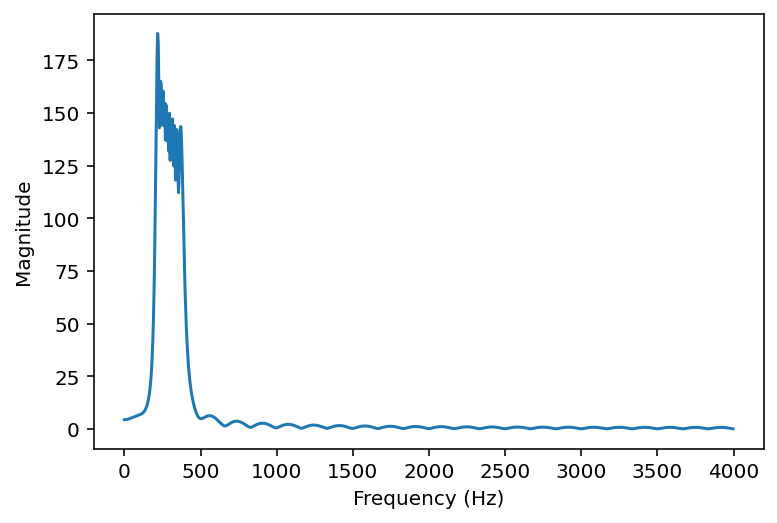

In [30]:
chirp_X = simple_fft(chirp_xs)
frequency_magnitude(chirp_xs, Fs=8000)

This signal has a relatively complex frequency spectrum compared to others we've seen. We can hear the result of applying the Inverse Fourier Transform (there is a fast version, that uses similar tricks to the FFT proper):

In [31]:
chirp_xs_rec = ifft(chirp_X)
ipd.Audio(chirp_xs_rec, rate=8000)

/apps/jupyterhub/COMP3717/lib/python3.8/site-packages/IPython/lib/display.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


/apps/jupyterhub/COMP3717/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


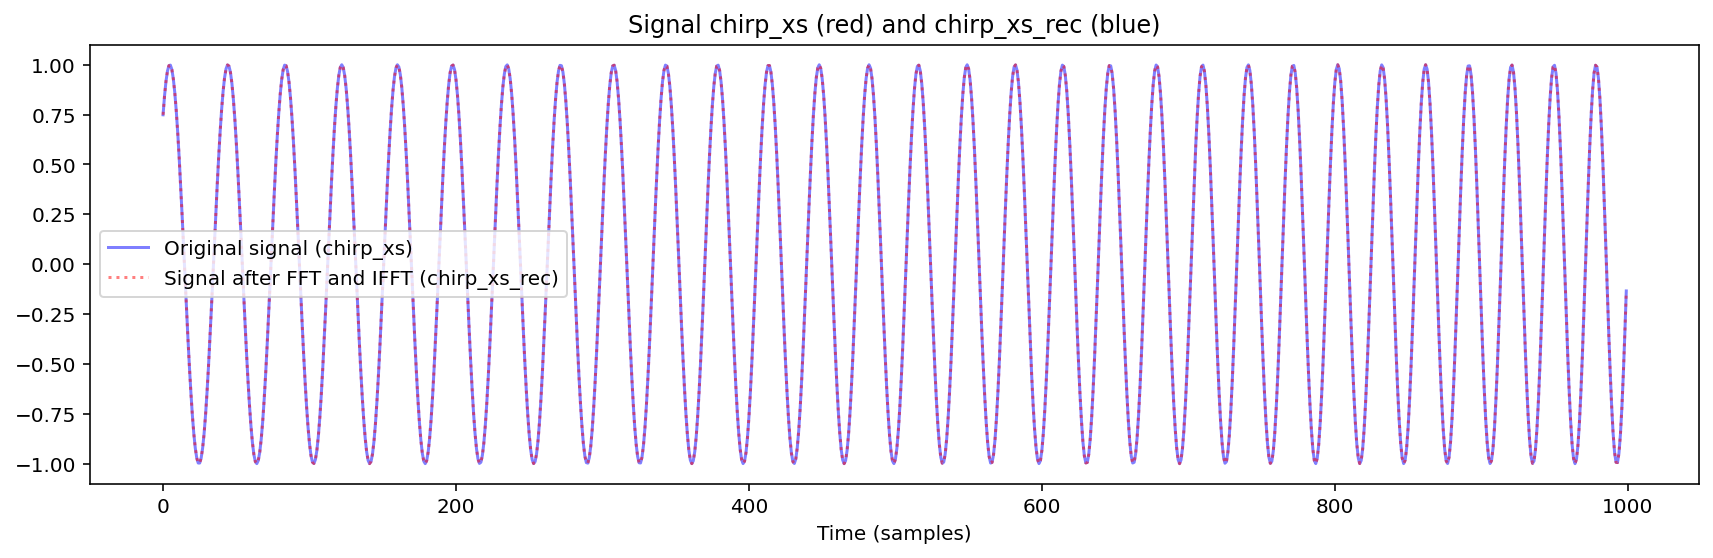

In [32]:
plt.figure(figsize=(12, 4))
plt.plot(chirp_xs[:1000], color='blue', alpha=0.5, label='Original signal (chirp_xs)')
plt.plot(chirp_xs_rec[:1000], color='red', linestyle=':', alpha=0.5, label='Signal after FFT and IFFT (chirp_xs_rec)')
plt.title('Signal chirp_xs (red) and chirp_xs_rec (blue)')
plt.xlabel('Time (samples)');
plt.legend()
plt.tight_layout()
plt.show()

Well, if we can do the Inverse Fourier Transform, we can imagine that this story generalises to the Inverse Short-Time Fourier Transform. 

What this looks like in practice is that we can convert between spectrogram representations of a sound (which are the result of applying the STFT) and the time-domain representation of the signal, by using the pair of functions `librosa.stft` and `librosa.istft`. 

We use the `librosa` implementations here because they are more appropriate for longer signals, but you can study the `libfmp` equivalents [by consulting the docs and source](https://meinardmueller.github.io/libfmp/build/html/index_c2.html#libfmp.c2.c2_fourier.istft) if you are looking for pointers about the general concepts involved.

Listen to the following recording:



In [33]:
voice_xs, voice_Fs = librosa.load('./EB-440.wav', sr=16000)
ipd.Audio(voice_xs, rate=voice_Fs)

`librosa` provides wrappers around `matplotlib` to plot spectrograms, given a matrix of spectral vectors - which may or may not come from the STFT (but do in our case), including taking care of the rebinning we discussed in lecture that can be used to produce log-spectrograms. 

But sometimes it needs a bit of help from the user. In particular, `librosa.display.specshow` needs to know the `hop_length` that was used to produce the STFT in order to correctly label the time axis. You can also change the timebase and frequency spacing of the x- and y-axes using the `x_axis` and `y_axis` arguments, respectively. Have a look a the magnitude log-spectrogram representation of the recording with the sine tone noise below:

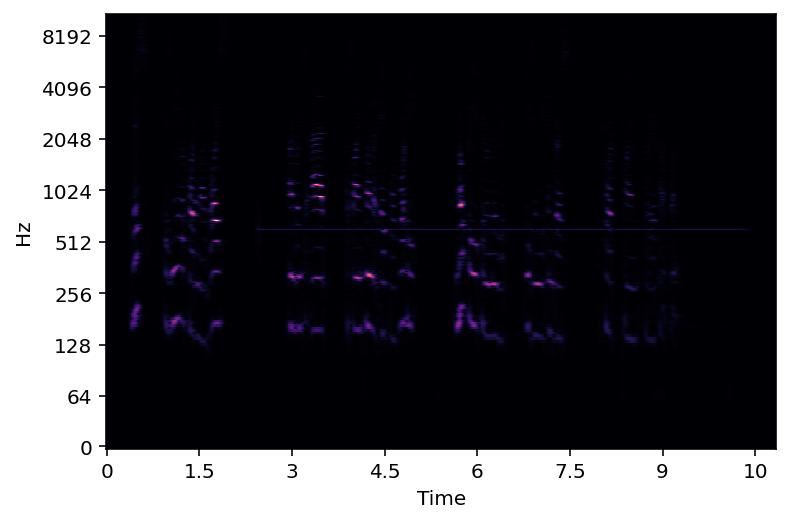

In [34]:
D = librosa.stft(voice_xs, hop_length=256, n_fft=4096)
librosa.display.specshow(np.abs(D), hop_length=256, 
                               x_axis='time', y_axis='log')
plt.show()

We can use `librosa` to rescale the amplitude values to a new unit, which better reflects the perception of loudnessL 

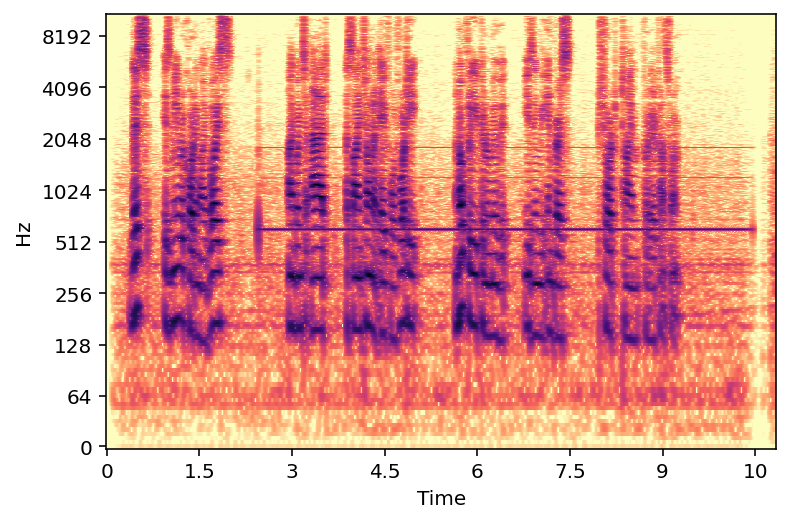

In [35]:
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
librosa.display.specshow(np.abs(S_db), hop_length=256, 
                               x_axis='time', y_axis='log')
plt.show()

Write a function `tone_removal(x, Fs, cf, start_time, end_time)` that uses the Inverse Short-Time Fourier Transform (ISTFT) to remove a sine tone of center frequency `cf`, beginning and ending at a specified time in seconds.

The basic idea is to manipulate the result of applying the STFT to the input signal in some way, and then to use the ISTFT to resynthesize the signal in the time-domain.

Hint: You will need to study the spectrogram to determine when the tone begins and ends, and perform some computations to identify the appropriate region of the spectrogram to "null out".

In [39]:
def tone_removal(x, Fs, cf, start_time, end_time):
    """Removes presence of a continuous sine tone of 
         given center frequency from recorded sound signal
         using Inverse Short-Time Fourier Transform.

    Args:
        x (np.ndarray): Signal to be transformed
        Fs (int): Sample rate
        cf (scalar): Center frequency of sine tone (Hz)
        start_time (scalar): Time to start noise suppression
        end_time (scalar): Time to end noise suppression
        w (np.ndarray): Window function

    Returns:
        y_hat (np.ndarray): The signal with the tone removed
    """
    W = 2048
    H = W // 4
    D = librosa.stft(x, win_length=W, hop_length=H)
    
    # STUDENT VERSION CHANGES HERE
    mask = np.ones_like(D)
    
    def time_to_frame(t):
        return int(t * (Fs/H))
    
    def cf_to_component(cf):
        return int(np.floor(cf * (W/Fs)))
    
    mask[cf_to_component(cf)-10:cf_to_component(cf)+10,time_to_frame(start_time):time_to_frame(end_time)] = False
    D_masked = np.where(mask, D, 0)

    y_hat = librosa.istft(D_masked)
    return y_hat

In [40]:
re = tone_removal(voice_xs, voice_Fs, 440, 6, 12)
ipd.Audio(re, rate=voice_Fs)